In [32]:
import pandas as pd
import datetime
from tqdm.auto import tqdm
tqdm.pandas()
from pandarallel import pandarallel
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
import numpy as np
pandarallel.initialize()

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


source: https://www.kaggle.com/oalvay/enron-emails-complete-preprocessing?select=emails_cleaned.csv 

In [92]:
emails_cleaned = pd.read_csv('emails_cleaned.csv')
emails_cleaned = emails_cleaned[["Date", "From", "To"]]

def str2datetime(Date):
    Date = Date.split("(")[0]
    date_time_obj = datetime.datetime.strptime(Date, '%a, %d %b %Y %H:%M:%S %z ')
    return date_time_obj.date()

dates = emails_cleaned['Date'].apply(str2datetime)
# dates = pd.to_datetime(dates, infer_datetime_format=True)


In [93]:
emails_cleaned.insert(0,'Dates',dates)
emails_cleaned = emails_cleaned.drop(columns = ['Date'])
emails_cleaned = emails_cleaned.dropna()
emails_cleaned = emails_cleaned.drop_duplicates()
emails_cleaned = emails_cleaned.sort_values(by=['Dates'])

In [94]:
df_checkaddrnum = pd.DataFrame(columns=['Dates', 'From', 'To'])
def checkaddrnum(row):
    global df_checkaddrnum
    # df_checkaddrnum = pd.DataFrame(columns=['Dates', 'From', 'To'])
    if ' ' in row['To']:
        temp = row['To'].split(',')

        for item in temp:
            df_checkaddrnum = df_checkaddrnum.append({'Dates': row['Dates'], 'From': row['From'], 'To': item.strip()}, ignore_index=True)
        # return df_checkaddrnum = pd.DataFrame(columns=['Dates', 'From', 'To'])
def checkcomma(row):
    if ',' in row: return True
    else: return False

In [95]:
emails_cleaned.parallel_apply(checkaddrnum, axis=1)
emails_cleaned.insert(3, 'Checkcomma', emails_cleaned['To'].parallel_apply(checkcomma))
emails_cleaned.drop(emails_cleaned[emails_cleaned['Checkcomma'] == True].index, inplace = True)
emails_cleaned = emails_cleaned.append(df_checkaddrnum)
emails_cleaned = emails_cleaned.drop(columns = 'Checkcomma')
emails_cleaned = emails_cleaned.sort_values(by=['Dates'])


In [101]:
emails_cleaned

Dates                      From  \
443793  0001-05-30  payables.ibuyit@enron.co   
342330  0001-06-07  payables.ibuyit@enron.co   
390578  0001-06-18  payables.ibuyit@enron.co   
391543  0001-07-24  payables.ibuyit@enron.co   
288078  0001-08-01  payables.ibuyit@enron.co   
...            ...                       ...   
174655  2007-02-11   rwalker802@earthlink.ne   
43809   2020-12-24        jody421@hotmail.co   
43852   2020-12-29        jody421@hotmail.co   
517038  2044-01-02       cramer@cadvision.co   
517035  2044-01-04       cramer@cadvision.co   

                                             To  
443793                   jeff.skilling@enron.co  
342330                      scott.neal@enron.co  
390578                holden.salisbury@enron.co  
391543                holden.salisbury@enron.co  
288078                  michelle.lokay@enron.co  
...                                         ...  
174655                     kevin.hyatt@enron.co  
43809   undisclosed.recipients@mailman.enron.co  
43852   undisclosed.recipients@mailman.enron.co  
517038                   john.zufferli@enron.co  
517035                   john.zufferli@enron.co  

[139390 rows x 3 columns]

In [104]:
emails_cleaned.to_csv(r'./emails_cleaned_Eric.csv', index = False)

# running deepwalk and get the .embeddings file for PCA and Kmeans 

In [9]:
dw_input = pd.read_csv('emails_cleaned_Eric.csv')
# dw_input.to_csv(r'./dw_input.edgelist', index = False, header = False, sep=' ')

each address is encoded into one number, email_id_lookup is a dictionary for finding the corresonding address

In [30]:
email_id_lookup = { email: x for x, email in enumerate(list(set(pd.concat([dw_input['From'], dw_input['To']]))))}
def addr_encode(row):
    row = email_id_lookup[row]
    return row
d = {'col1': dw_input['From'].apply(addr_encode), 'col2': dw_input['To'].apply(addr_encode)}
df = pd.DataFrame(data=d)
df.to_csv(r'./dw_input.edgelist', index = False, header = False, sep=' ')


In [26]:
# emb = pd.read_csv('./deepwalk/dw_output.embeddings')
with open('./deepwalk/dw_output.embeddings') as f:
    content =  f.readlines()
# txt = (str(emb.loc[0])).split()
# pd.DataFrame(content)
# (content[2].split())

emb = pd.DataFrame()
df = pd.DataFrame()
for i in tqdm(range(1, len(content))):
    s = pd.Series(list(map(float, (content[i].split()))))
    df = pd.concat([df, s.to_frame().T])
df
# content[1].split()
# txt.split()

100%|██████████| 18808/18808 [00:34<00:00, 544.31it/s]


0         1         2         3         4         5         6   \
0    7370.0 -0.142477  0.436860  0.235192 -0.356195  0.216916 -0.332582   
0    3356.0 -0.385867  0.094048  0.629583 -0.212466 -0.128917  1.017284   
0    1090.0  0.171568  0.585491 -0.631216  0.326484  0.194037  0.501582   
0    4384.0 -0.842428 -0.351559  0.827852 -0.527727  0.472489  0.010413   
0   17968.0  0.161608  0.810705  0.483151 -0.593295 -0.017127  0.241571   
..      ...       ...       ...       ...       ...       ...       ...   
0   19588.0 -0.005800  0.007780  0.007682  0.005999 -0.000665  0.004957   
0     222.0  0.001511  0.000024  0.006638  0.004670  0.007399  0.003921   
0    9453.0  0.006819  0.001749 -0.000264 -0.000184  0.006572  0.003906   
0   15120.0 -0.004260  0.004519 -0.006716 -0.001426  0.003061  0.003728   
0   25003.0  0.007581 -0.000701  0.003692  0.002235 -0.001556  0.000221   

          7         8         9   ...        55        56        57        58  \
0   0.732800 -0.443598 -0.409908  ... -0.142514  0.567609 -0.463584  0.512752   
0   0.070213 -0.183890  0.018782  ...  0.194499  0.098836  0.487198  0.008140   
0  -0.577552 -0.323383 -0.281627  ... -0.416863  0.398230  0.150195  0.273009   
0  -0.520913 -0.229553 -0.250046  ... -0.809069  0.012637  0.120847 -0.337596   
0   0.845141  0.205770  0.097156  ... -0.889612  0.292638  0.355418  0.246132   
..       ...       ...       ...  ...       ...       ...       ...       ...   
0  -0.000462 -0.002053  0.005377  ... -0.007482  0.006633 -0.001560 -0.005892   
0   0.005770 -0.003498  0.003555  ... -0.002906 -0.007318 -0.006431 -0.002781   
0   0.004223 -0.000737 -0.005635  ...  0.002032 -0.006851 -0.007224  0.006126   
0   0.003455 -0.003816  0.007678  ... -0.000977  0.006676  0.006241 -0.003533   
0  -0.006251  0.006293 -0.004546  ...  0.002402 -0.004141 -0.004992 -0.007574   

          59        60        61        62        63        64  
0  -0.125765 -0.626673 -0.432479 -0.342420 -0.204675  0.139262  
0  -0.460324 -0.683740 -0.462465  0.528810 -0.663343  0.435084  
0  -0.608169 -0.878455  0.445144 -0.027112 -0.016575  0.726486  
0   0.185841 -0.956282  0.477354  0.241935  0.093052  0.949549  
0  -0.095550 -0.627579 -0.476127 -0.026532  0.125944  0.701732  
..       ...       ...       ...       ...       ...       ...  
0  -0.006253  0.006568 -0.005688 -0.000470 -0.005862  0.004932  
0  -0.004551  0.005245  0.001058  0.004978 -0.007805  0.005256  
0  -0.000818 -0.005280  0.004183  0.007603 -0.004746 -0.002869  
0  -0.006678 -0.006023  0.007241  0.006264 -0.003914 -0.007661  
0   0.007079 -0.007536  0.002877 -0.006153  0.000178 -0.005005  

[18808 rows x 65 columns]

standardize the input

In [28]:
df = df.rename(columns={0:'encoded address'})
df = df.reset_index()
df
X = df.to_numpy()
scaler = StandardScaler()
X = scaler.fit_transform(X)
X

array([[-1.73195872e+00,  0.00000000e+00, -7.24680375e-01, ...,
        -5.71266250e-01, -5.31277244e-01, -7.49287840e-01],
       [-1.73177454e+00,  0.00000000e+00, -1.27266383e+00, ...,
         9.07026499e-01, -1.30079026e+00, -3.40586824e-01],
       [-1.73159035e+00,  0.00000000e+00, -1.58201373e+00, ...,
        -3.62550739e-02, -2.15698415e-01,  6.20090605e-02],
       ...,
       [ 1.73159035e+00,  0.00000000e+00, -4.40313276e-01, ...,
         2.26491524e-02, -1.95852842e-01, -9.45652938e-01],
       [ 1.73177454e+00,  0.00000000e+00,  3.33334515e-01, ...,
         2.03772123e-02, -1.94457662e-01, -9.52273017e-01],
       [ 1.73195872e+00,  0.00000000e+00,  1.68254241e+00, ...,
        -6.91919066e-04, -1.87592517e-01, -9.48604249e-01]])

run PCA and kmeans 

In [29]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents,columns = ['principal component 1', 'principal component 2'])#, 'principal component 3', 'principal component 4'])
finalDf = pd.concat([principalDf, pd.DataFrame(df['encoded address'])], axis = 1)
# finalDf.insert(0, 'encoded address', , False)

finalDf

principal component 1  principal component 2  encoded address
0                  -0.025091              -0.802491           7370.0
1                  -0.096380              -0.236466           3356.0
2                   0.059312              -0.113553           1090.0
3                  -0.090295              -0.846142           4384.0
4                  -0.066121              -1.027393          17968.0
...                      ...                    ...              ...
18803              -0.915145              -1.069097          19588.0
18804              -0.921862              -1.043654            222.0
18805              -0.910284              -1.044075           9453.0
18806              -0.906976              -1.064140          15120.0
18807              -0.896037              -1.067195          25003.0

[18808 rows x 3 columns]

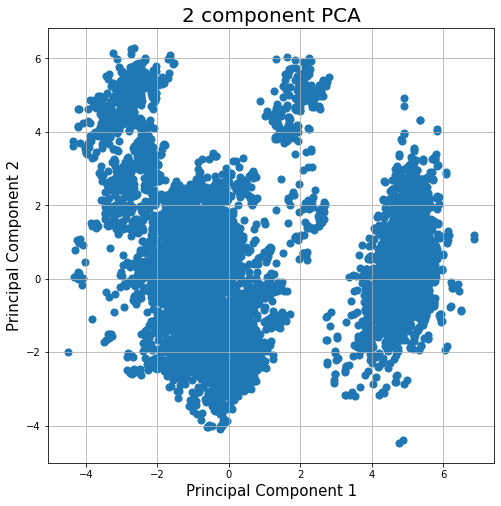

In [30]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
   
ax.scatter(finalDf['principal component 1'],
           finalDf['principal component 2'],
           s = 50)

ax.grid()

<Figure size 864x864 with 0 Axes>

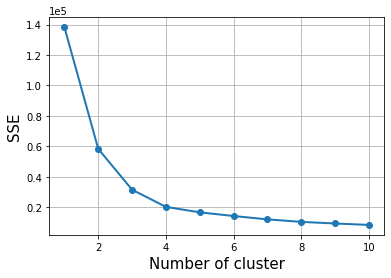

In [33]:
PC1 = pd.DataFrame(finalDf['principal component 1'])
PC2 = pd.DataFrame(finalDf['principal component 2'])
PC12 = pd.concat([PC1,PC2], axis = 1)
PC12 = PC12.to_numpy()


plt.figure(figsize=(12, 12))
SSE = {}

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=10, max_iter=1000).fit(PC12)
    SSE[k] = kmeans.inertia_ 



plt.figure()
plt.plot(list(SSE.keys()), list(SSE.values()), linewidth=2.0, marker = 'o')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.xlabel("Number of cluster", fontsize = 15)
plt.ylabel("SSE", fontsize = 15)
plt.grid(True)

plt.show()


Text(0.5, 1.0, 'K = 4')

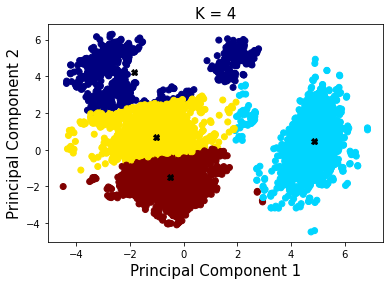

In [34]:
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=10)
y_pred = kmeans.fit_predict(PC12)


plt.scatter(PC12[:, 0], PC12[:, 1], c = y_pred, cmap='jet')
plt.plot(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],'X', color = 'black' )
plt.xlabel('Principal Component 1', fontsize = 15)
plt.ylabel('Principal Component 2', fontsize = 15)
plt.title("K = 4", fontsize = 15)